# Context

For the Bayesian Hospital-in-a-Box paper (https://www.overleaf.com/project/65f1780930fa7aa758dc83d8) we end up with the following likelihood:

\begin{equation}
    p(T=t) \propto p(C=0) \left[ (\text{Exp}(t; \lambda_r) - \text{Exp}(t; \lambda_l))
    + \sum_{n=2}^{N_l^{\text{max}}} p(C=1)^{n-1}\int_0^t \text{Exp}(t_r; \lambda_r) \text{Gamma}(t - t_r; n, \lambda_l) dt_r \right]
\end{equation}
where the convolution integral

\begin{equation}
  \int_0^t \text{Exp}(t_r; \lambda_r) \text{Gamma}(t - t_r; n, \lambda_l) dt_r
\end{equation}
where $\lambda_r,\lambda_l>0$ and $n$ is a positive integer, does not, to the best of our knowledge, have a known closed-form solution. We therefore chose to approximate the integral using a Monte-Carlo sampling approach. Defining

\begin{equation}
  T_r \sim \text{Exp}(\lambda_r), \quad
  T_l \sim \text{Gamma}(n, \lambda_l), \quad T_{r+l} = T_r + T_l
\end{equation}
then our convolution integral is, by definition, an approximation for $p(T_{r+l}=t_{r+l})$. In this document we descripe and validate our Monte Carlo estimates of $p(T_{r+l}=t_{r+l})$.

# Example Problem

Here, we define an example problem and generate some data.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import expon
from scipy.stats import gamma

Text(0.5, 0, '$t_{r+l}$')

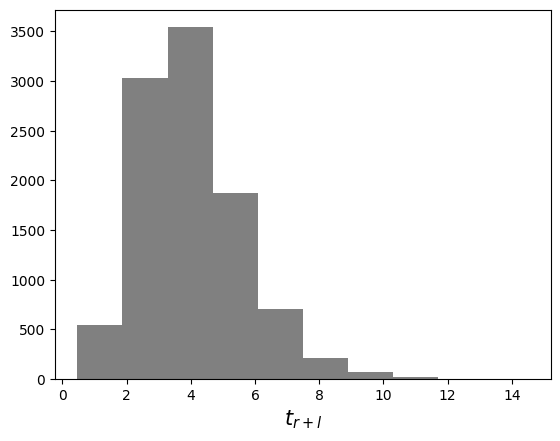

In [ ]:
# Set up the distribution parameters
lambda_r = 1
lambda_l = 2
n = 6

# Define exponential and gamma distributions
p_r = expon(scale=1/lambda_r)
p_l = gamma(a=n, scale=1/lambda_l)

# Generate samples
N = 10000
t_r_samples = p_r.rvs(N)
t_l_samples = p_l.rvs(N)
t_r_plus_l_samples = t_r_samples + t_l_samples

# Plot histogram of samples
fig, ax = plt.subplots()
t_bin_values, t_bins = plt.hist(t_r_plus_l_samples, color='grey')[0:2]
ax.set_xlabel('$t_{r+l}$', fontsize=15)

# Monte-Carlo Estimate


In general, we seek a Monte-Carlo estimate of
\begin{equation}
  p_{r+l}(t_{r+l}) = \int_0^{t_{r+l}} p_l(t_{r+l} - t_r) p_r(t_r) d t_r
\end{equation}
where, in this case, $p_r(t_r) = \text{Exp}(t_r; \lambda_r)$ and $\text{Gamma}(n, \lambda_l)$. To realise our estimate we define

\begin{equation}
  f(t_l, t_{r+l}) =
  \begin{cases}
    p_l(t_l), & \text{if } t_l \in [0, t_{r+l}] \\
    0, & \text{otherwise}
  \end{cases}
\end{equation}
We then compute

\begin{equation}
  F(t_{r+l}) = \frac{1}{N} \sum_{i=1}^N  f(t_{r+l} - T_r^{(i)}, t_{r+l}), \quad T_r^{(i)}\sim p_r(t_r)
\end{equation}
We note that

\begin{equation*}
  \text{E}[F(t_{r+l})] = \frac{1}{N} \sum_{i=1}^N \text{E}[f(t_{r+l} - T_r^{(i)}, t_{r+l})] =
    \text{E}[f(t_{r+l} - T_r, t_{r+l})]
\end{equation*}

\begin{equation}
  = \int_{-\infty}^{\infty} f(t_{r+l} - t_r) p_r(t_r) dt_r = \int_0^{t_{r+l}}p_l(t_{r+l} - t_r) p_r(t_r) d t_r    
\end{equation}
therefore proving that the average of $F$ is equal to the convolution integral, evaluated at the point $t_{r+l}$.

In [ ]:
def f(t_l, t_r_plus_l):
  """ Function that is equal to pl(tl) if t_l \in [0, t_{r+l}] and
    0 otherwise.
  """

  output = p_l.pdf(t_l)               # p_l evaluated over all t_l values
  zero_locations = t_l > t_r_plus_l   # Locations where t_l \notin [0, t_{r+l}]
  output[zero_locations] = 0          # Set appropriate locations equal to 0
  return output

In [ ]:
t_r_plus_l_range = np.linspace(0, t_bins[-1], 100)    # Range over which we'll evaluate our Monte-Carlo estiamte
p_t_plus_l = np.zeros(len(t_r_plus_l_range))          # Initialise array of probabilities

# Evaluate Monte Carlo estimate over t_r_plus_l_range
for i, t_r_plus_l in enumerate(t_r_plus_l_range):
  p_t_plus_l[i] = np.mean(f(t_r_plus_l - t_r_samples, t_r_plus_l))

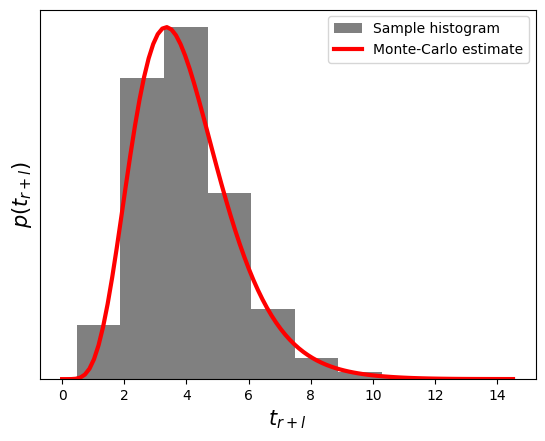

In [ ]:
# Plot results and compare with histogram
fig, ax = plt.subplots()
ax.hist(t_r_plus_l_samples, color='grey', label='Sample histogram')
ax.plot(t_r_plus_l_range, p_t_plus_l / np.max(p_t_plus_l) * np.max(t_bin_values), color='red', linewidth=3, label='Monte-Carlo estimate')
ax.set_xlabel('$t_{r+l}$', fontsize=15)
ax.set_ylabel('$p(t_{r+l})$', fontsize=15)
ax.set_yticks([])
ax.legend()